# HVG:seurat_v3 & harmony workflow
**Author:** [Severin Dicks](https://github.com/Intron7)

To run this notebook please make sure you have a working rapids enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import scanpy as sc
import anndata
import cupy as cp

import time
import rapids_singlecell as rsc
from rapids_singlecell.cunnData import cunnData

import warnings
warnings.filterwarnings("ignore")

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/adata.raw.h5ad")

CPU times: user 2.51 s, sys: 219 ms, total: 2.73 s
Wall time: 2.73 s


In [5]:
%%time
cudata = rsc.cunnData.cunnData(adata=adata)

CPU times: user 80.2 ms, sys: 284 ms, total: 364 ms
Wall time: 363 ms


In [6]:
adata.shape

(93575, 33694)

We now load the the AnnData object into a cunnData object. cunnData objects can be used as a replacement for scanpy and AnnData for the preprocessing. All functions are methods of the class.

Verify the shape of the resulting sparse matrix:

In [7]:
cudata.shape

(93575, 33694)

And the number of non-zero values in the matrix:

In [8]:
cudata.nnz

114212920

In [9]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 3.1219675540924072


## Preprocessing

In [10]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [11]:
%%time
rsc.pp.flag_gene_family(cudata,gene_family_name="MT", gene_family_prefix="MT-")

CPU times: user 6.35 ms, sys: 680 µs, total: 7.03 ms
Wall time: 6.96 ms


In [12]:
%%time
rsc.pp.flag_gene_family(cudata,gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 2.82 ms, sys: 3.66 ms, total: 6.48 ms
Wall time: 6.43 ms


In [13]:
%%time
rsc.pp.calculate_qc_metrics(cudata,qc_vars=["MT","RIBO"])

CPU times: user 94 ms, sys: 11.4 ms, total: 105 ms
Wall time: 105 ms


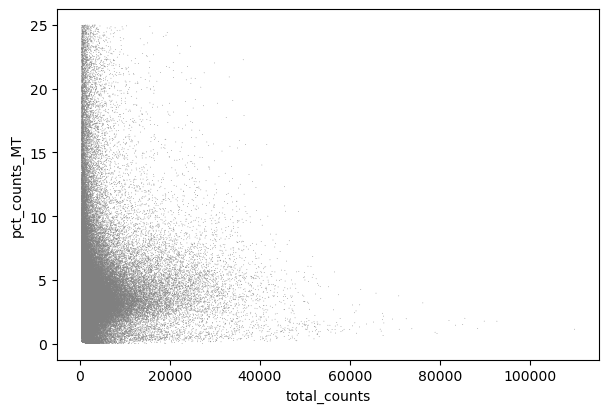

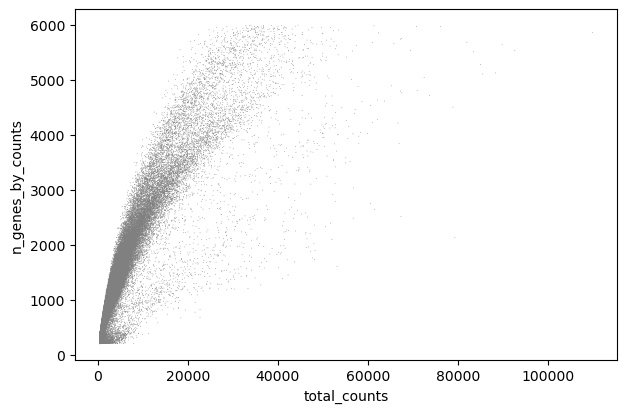

In [14]:
sc.pl.scatter(cudata, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(cudata, x='total_counts', y='n_genes_by_counts')

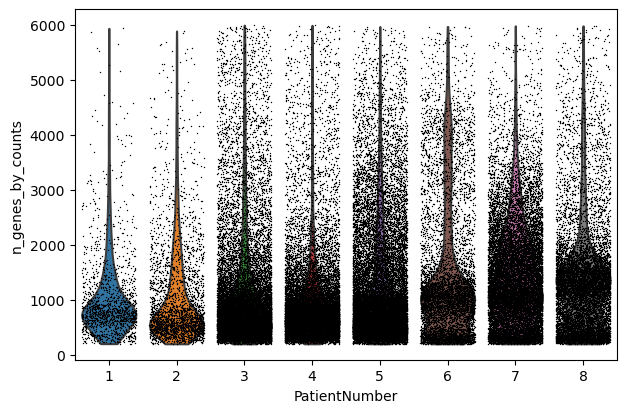

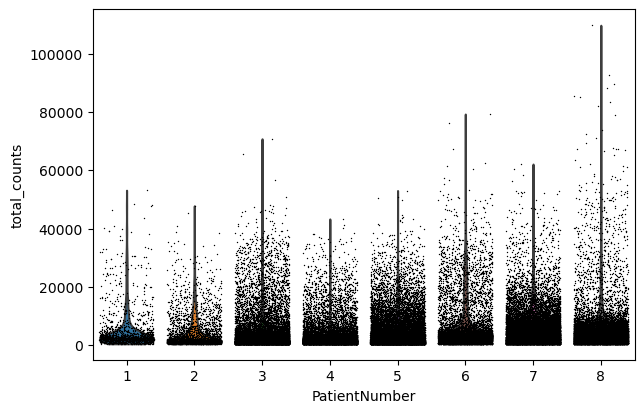

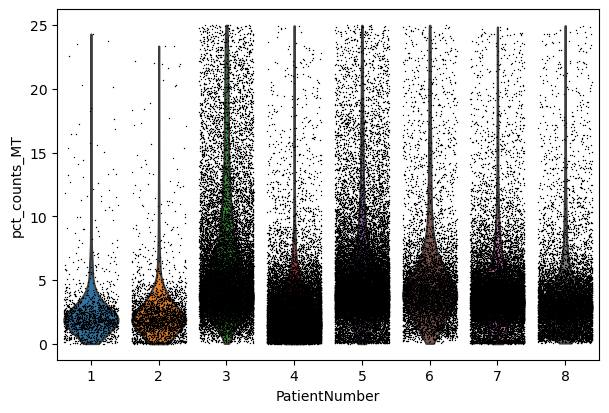

In [15]:
sc.pl.violin(cudata, 'n_genes_by_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(cudata, 'total_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(cudata, 'pct_counts_MT',jitter=0.4, groupby="PatientNumber")


### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [16]:
%%time
cudata = cudata[cudata.obs["n_genes_by_counts"] > 200]
cudata = cudata[cudata.obs["n_genes_by_counts"] < 5000]
cudata.shape

CPU times: user 125 ms, sys: 45.5 ms, total: 171 ms
Wall time: 170 ms


(92666, 33694)

In [17]:
%%time
cudata = cudata[cudata.obs["pct_counts_MT"] < 20]
cudata.shape

CPU times: user 57.9 ms, sys: 26.3 ms, total: 84.2 ms
Wall time: 83.9 ms


(91180, 33694)

We also filter out genes that are expressed in less than 3 cells.

In [18]:
%%time
rsc.pp.filter_genes(cudata,min_count=3)

filtered out 8034 genes based on n_cells_by_counts
CPU times: user 68.5 ms, sys: 32.7 ms, total: 101 ms
Wall time: 101 ms


We store the raw expression counts in the `.layer["counts"]`

In [19]:
cudata.layers["counts"] = cudata.X.copy()

In [20]:
cudata.shape

(91180, 25660)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [21]:
%%time
rsc.pp.normalize_total(cudata,target_sum=1e4)

CPU times: user 8.33 ms, sys: 4.48 ms, total: 12.8 ms
Wall time: 12.4 ms


Next, we log transform the count matrix.

In [22]:
%%time
rsc.pp.log1p(cudata)

CPU times: user 379 µs, sys: 16 ms, total: 16.4 ms
Wall time: 15.2 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`

In [23]:
%%time
rsc.pp.highly_variable_genes(cudata,n_top_genes=5000,flavor="seurat_v3",batch_key= "PatientNumber",layer = "counts")

CPU times: user 925 ms, sys: 2.75 s, total: 3.67 s
Wall time: 509 ms


Now we safe this verion of the cunndata object as an AnnData one. We'll use this as adata.raw later. 

In [24]:
%%time
bdata = cudata.to_AnnData()

CPU times: user 205 ms, sys: 118 ms, total: 323 ms
Wall time: 322 ms


Now we restrict our cunndata object to the highly variable genes.

In [25]:
%%time
cudata = cudata[:,cudata.var["highly_variable"]==True]

CPU times: user 111 ms, sys: 73.9 ms, total: 185 ms
Wall time: 184 ms


In [26]:
cudata.shape

(91180, 5000)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [27]:
%%time
rsc.pp.regress_out(cudata,keys=["total_counts", "pct_counts_MT"])

CPU times: user 639 ms, sys: 786 ms, total: 1.42 s
Wall time: 1.43 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [28]:
%%time
rsc.pp.scale(cudata,max_value=10)

CPU times: user 48.2 ms, sys: 16.3 ms, total: 64.5 ms
Wall time: 63.4 ms


In [29]:
X = cp.random.rand(90000,5000,dtype= cp.float32)

In [30]:
from cuml import PCA

pca_func = PCA(
    n_components=50, random_state=42, output_type="numpy"
)
X_pca = pca_func.fit_transform(X)

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from cuMLs.

In [31]:
%%time
rsc.pp.pca(cudata, n_comps = 100)

CPU times: user 715 ms, sys: 95 ms, total: 810 ms
Wall time: 809 ms


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

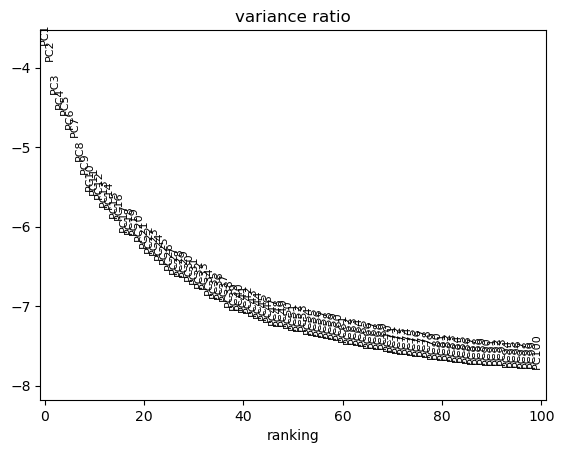

In [32]:
sc.pl.pca_variance_ratio(cudata, log=True,n_pcs=100)

Next we transfrom our cunnData object back to an AnnData object. We also set the normalized and logarithmized raw gene expression from bdata as adata.raw.

In [33]:
%%time
adata = cudata.to_AnnData()
adata.raw = bdata
del bdata, cudata

CPU times: user 211 ms, sys: 155 ms, total: 367 ms
Wall time: 366 ms


In [34]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 7.036063194274902


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using rsc.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [35]:
%%time
rsc.tl.harmony_integrate(adata,key="PatientNumber")

2023-08-15 13:45:04,865 - harmonypy_gpu - INFO - Iteration 1 of 10
2023-08-15 13:45:07,817 - harmonypy_gpu - INFO - Iteration 2 of 10
2023-08-15 13:45:10,808 - harmonypy_gpu - INFO - Iteration 3 of 10
2023-08-15 13:45:13,761 - harmonypy_gpu - INFO - Iteration 4 of 10
2023-08-15 13:45:16,724 - harmonypy_gpu - INFO - Iteration 5 of 10
2023-08-15 13:45:19,665 - harmonypy_gpu - INFO - Iteration 6 of 10
2023-08-15 13:45:22,371 - harmonypy_gpu - INFO - Converged after 6 iterations


CPU times: user 9.7 s, sys: 7.99 s, total: 17.7 s
Wall time: 17.7 s


In [36]:
%%time
rsc.tl.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 304 ms, sys: 32.3 ms, total: 336 ms
Wall time: 335 ms


Next we calculate the UMAP embedding using rapdis.

In [37]:
%%time
rsc.tl.umap(adata)

CPU times: user 382 ms, sys: 13.7 ms, total: 396 ms
Wall time: 394 ms


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [38]:
%%time
rsc.tl.louvain(adata, resolution=0.6)

CPU times: user 272 ms, sys: 504 ms, total: 775 ms
Wall time: 774 ms


In [39]:
%%time
rsc.tl.leiden(adata,resolution=0.6)

CPU times: user 300 ms, sys: 436 ms, total: 735 ms
Wall time: 735 ms


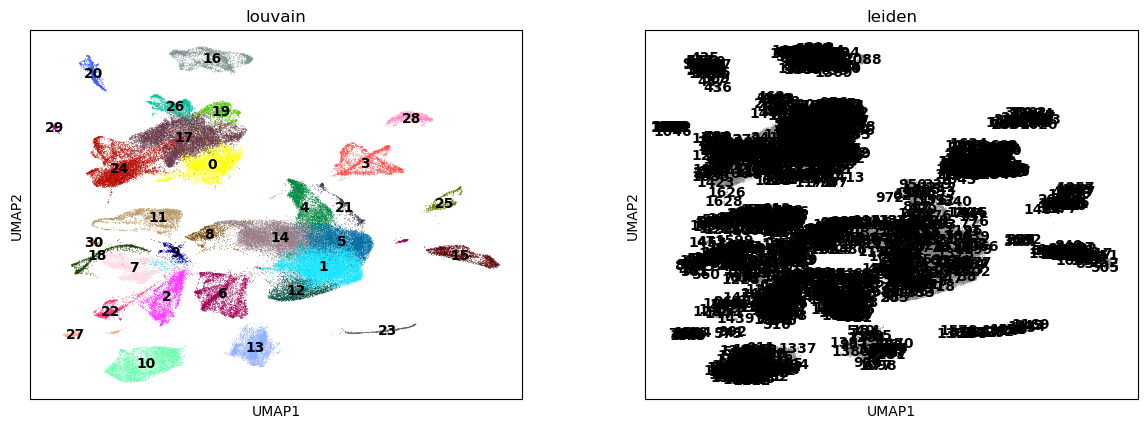

CPU times: user 2.2 s, sys: 172 ms, total: 2.37 s
Wall time: 2.22 s


In [40]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

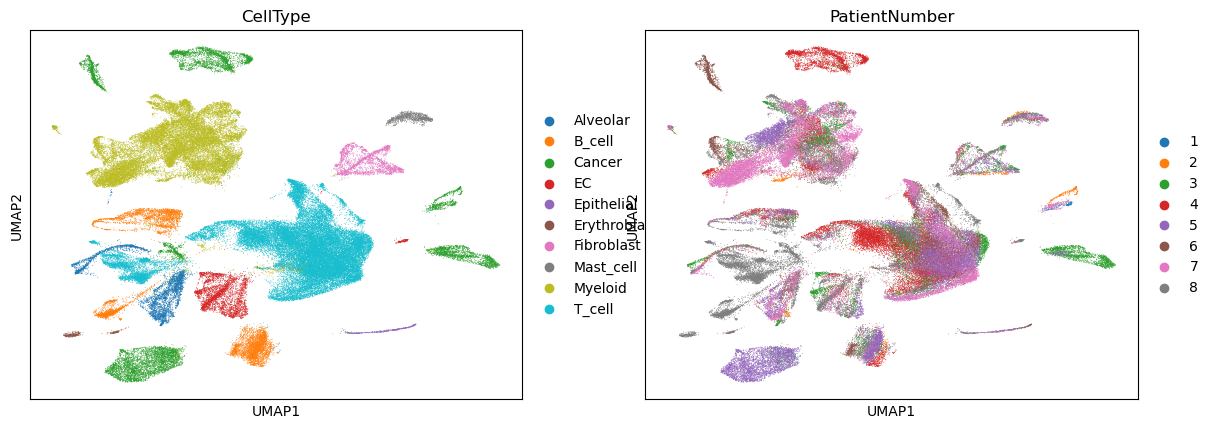

In [41]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

We also caluclate the embedding density in the UMAP using cuML

In [42]:
%%time
rsc.tl.embedding_density(adata, groupby="PatientNumber")

CPU times: user 801 ms, sys: 69.5 ms, total: 871 ms
Wall time: 870 ms


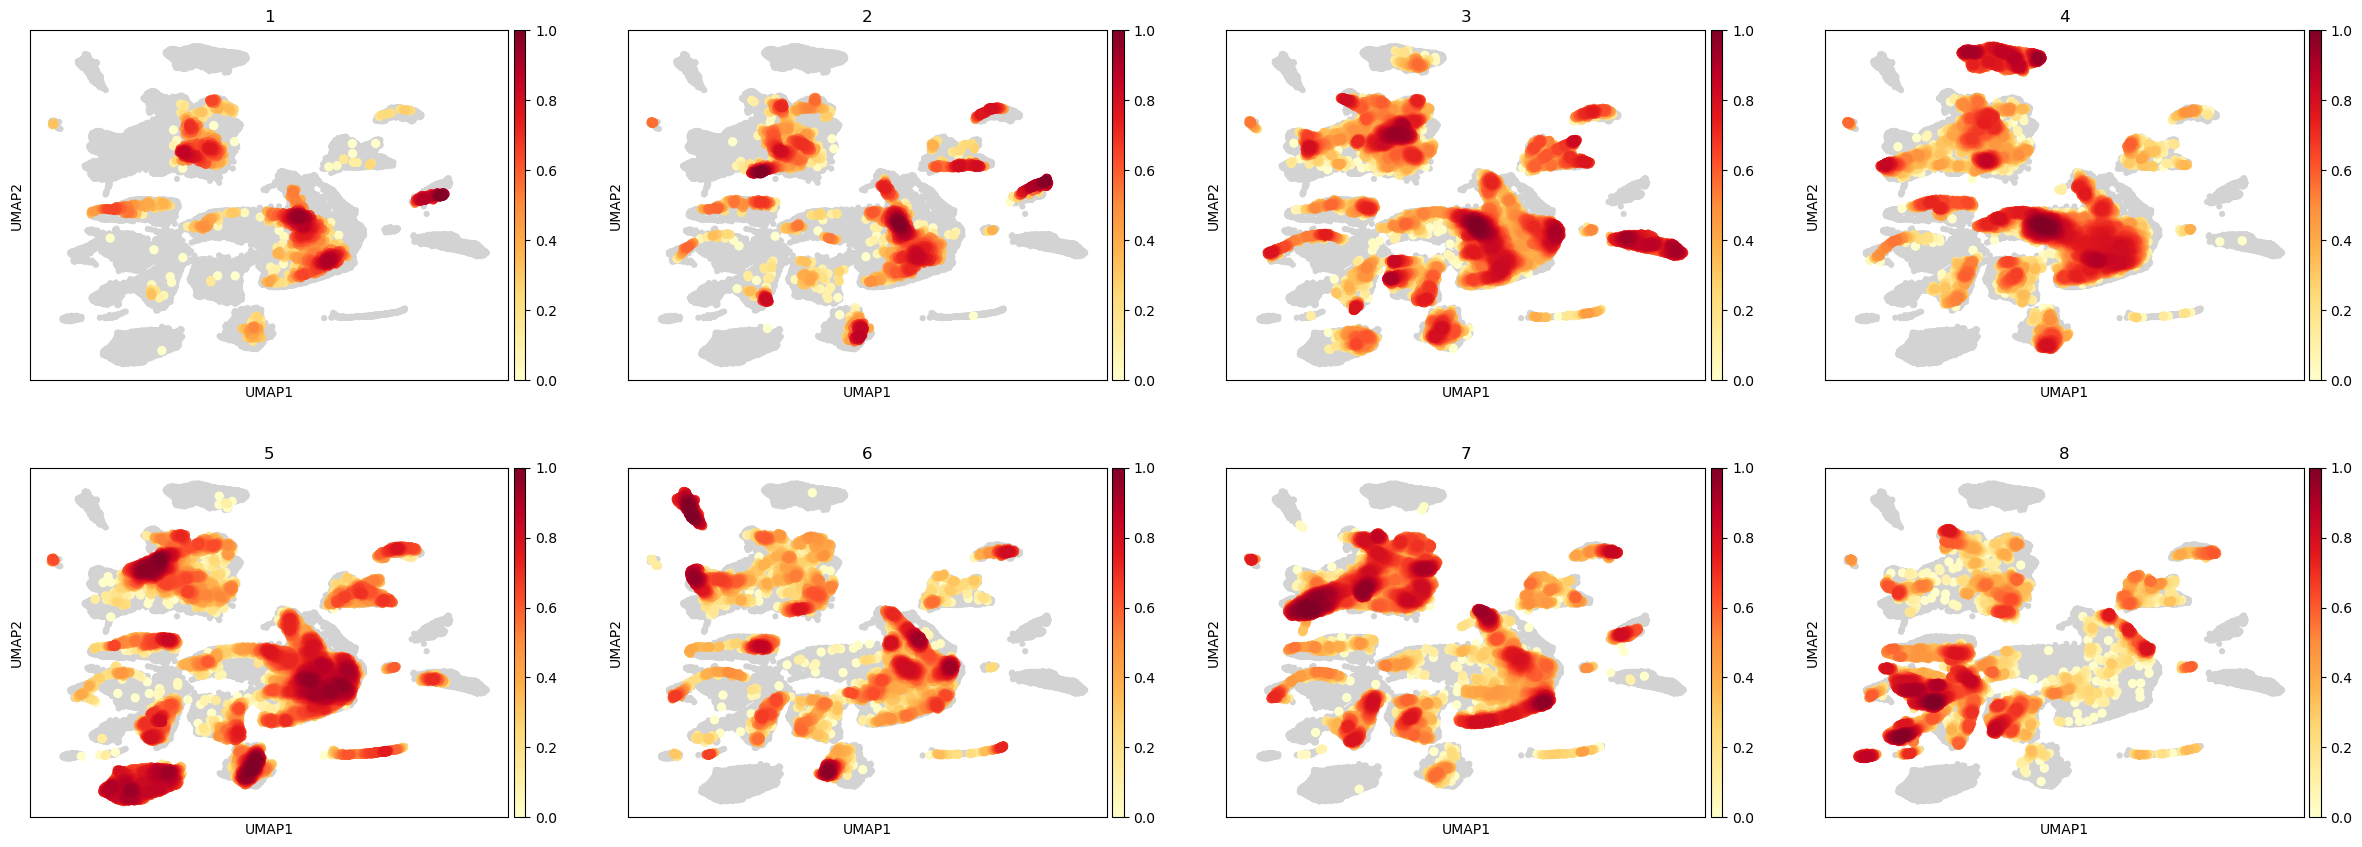

In [43]:
sc.pl.embedding_density(adata, groupby="PatientNumber")

### TSNE + k-Means

Next we use TSNE on the GPU to visualize the cells in two dimensions. We also perform k-Means clustering of the cells into 8 clusters.

In [44]:
%%time
rsc.tl.tsne(adata, n_pcs = 40)

[W] [13:45:31.703656] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 931 ms, sys: 875 ms, total: 1.81 s
Wall time: 1.79 s


In [45]:
rsc.tl.kmeans(adata, n_clusters=8)

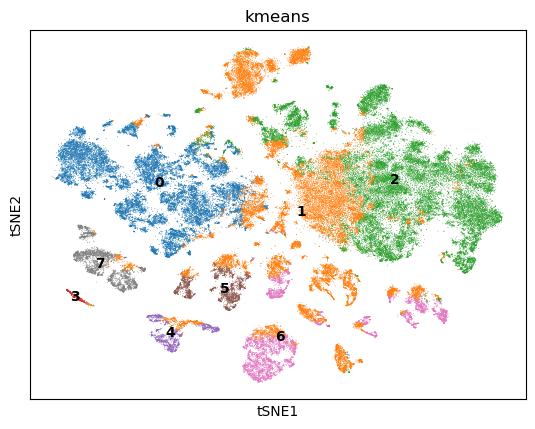

CPU times: user 381 ms, sys: 109 ms, total: 490 ms
Wall time: 346 ms


In [46]:
%%time
sc.pl.tsne(adata, color=["kmeans"],legend_loc = 'on data')

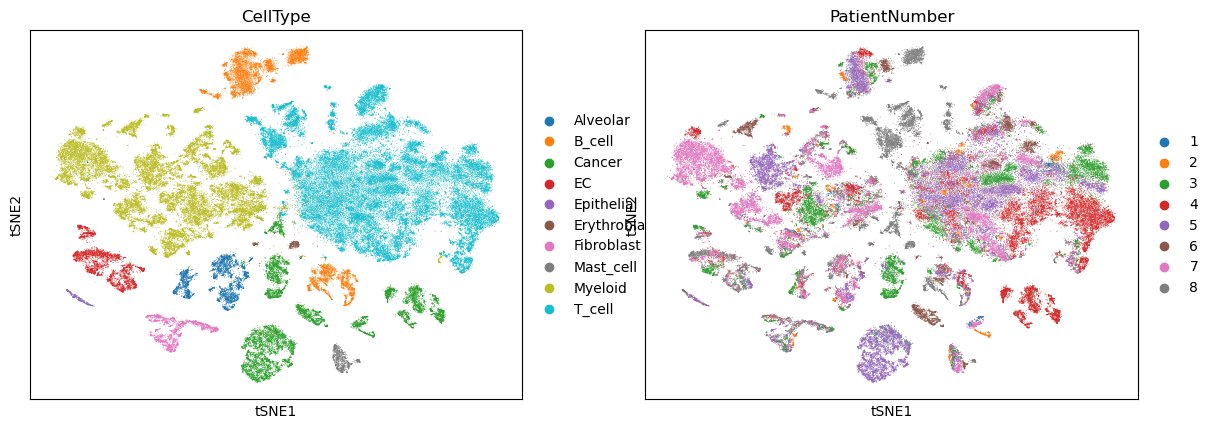

In [47]:
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [48]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="CellType", use_raw=False)

CPU times: user 1.98 s, sys: 1.07 s, total: 3.05 s
Wall time: 3.04 s


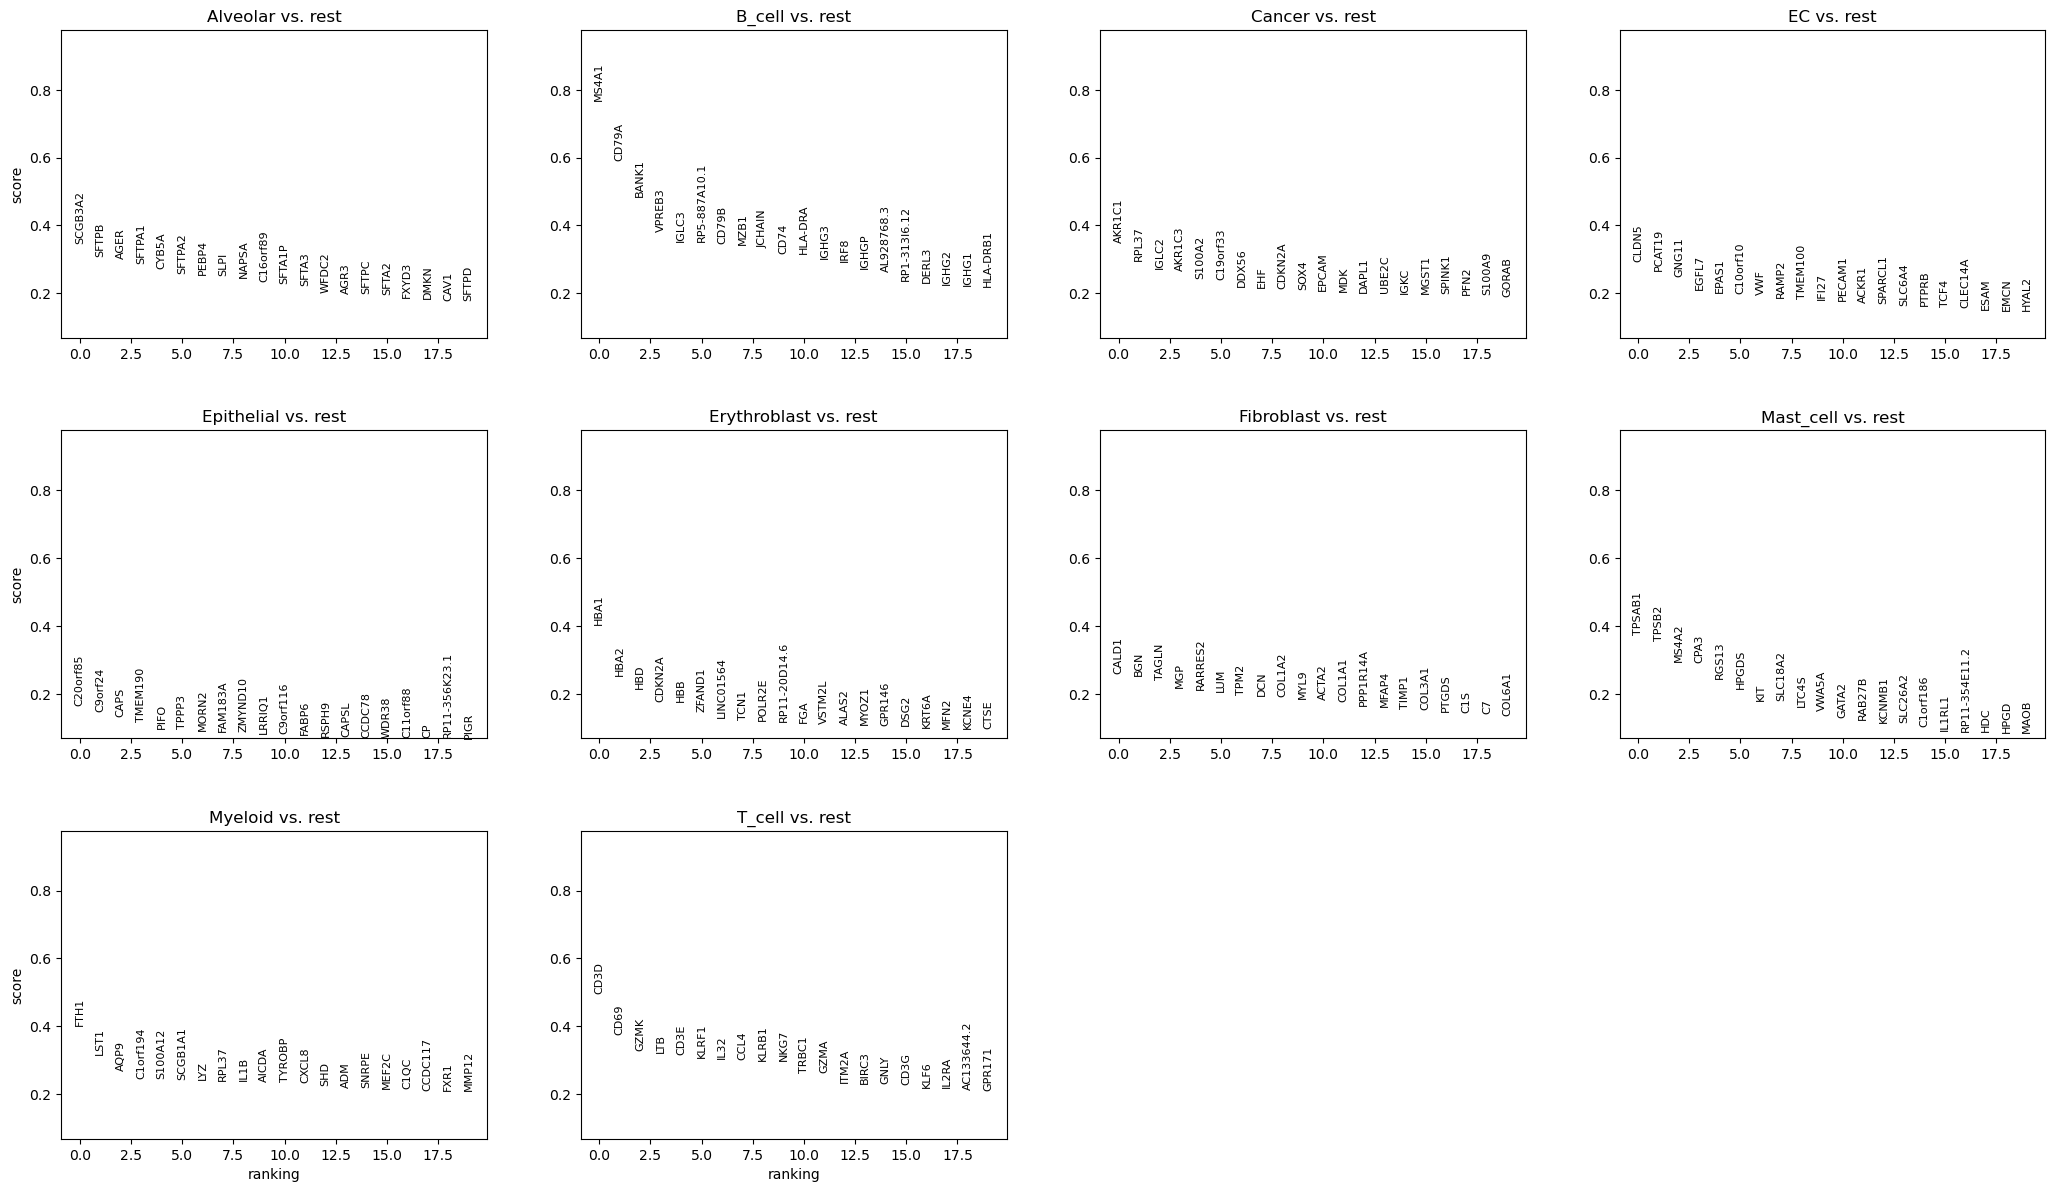

CPU times: user 1.17 s, sys: 116 ms, total: 1.29 s
Wall time: 1.14 s


In [49]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [50]:
post_time = time.time()

In [51]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 34.306341886520386


## Diffusion Maps

With cupy 9 its possible to compute Eigenvalues of sparse matrixes. We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [52]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:].copy()

We can repeat the dimension reduction, clustering and visulatization.

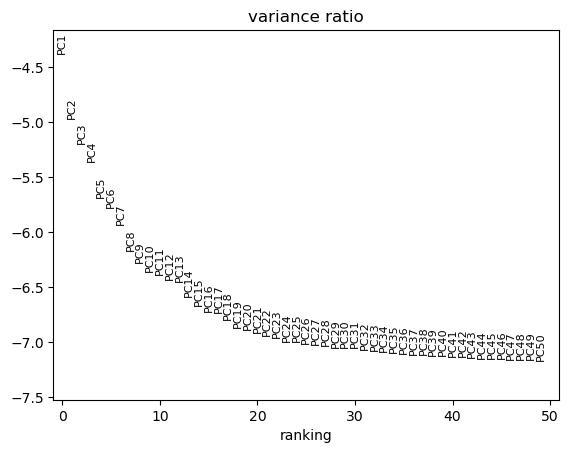

CPU times: user 888 ms, sys: 487 ms, total: 1.37 s
Wall time: 1.23 s


In [53]:
%%time
rsc.tl.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [54]:
%%time
rsc.tl.neighbors(tdata, n_neighbors=15, n_pcs=20)
rsc.tl.umap(tdata)
rsc.tl.louvain(tdata)

CPU times: user 347 ms, sys: 195 ms, total: 542 ms
Wall time: 543 ms


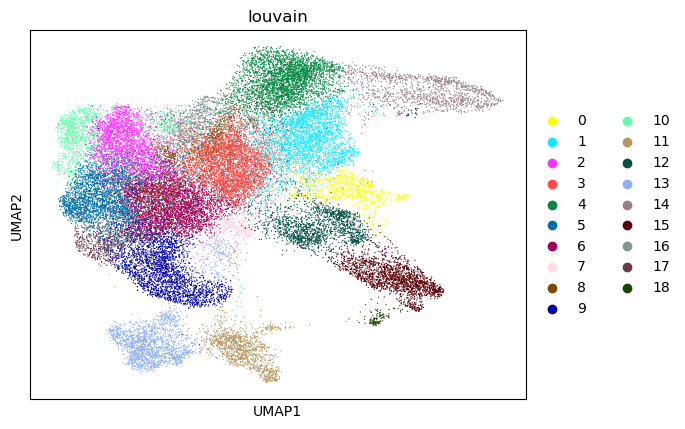

In [55]:
sc.pl.umap(tdata, color=["louvain"])

As stated before Diffusion Maps have become an integral part of single cell analysis.

In [56]:
%%time
rsc.tl.diffmap(tdata)

CPU times: user 197 ms, sys: 4.83 ms, total: 202 ms
Wall time: 201 ms


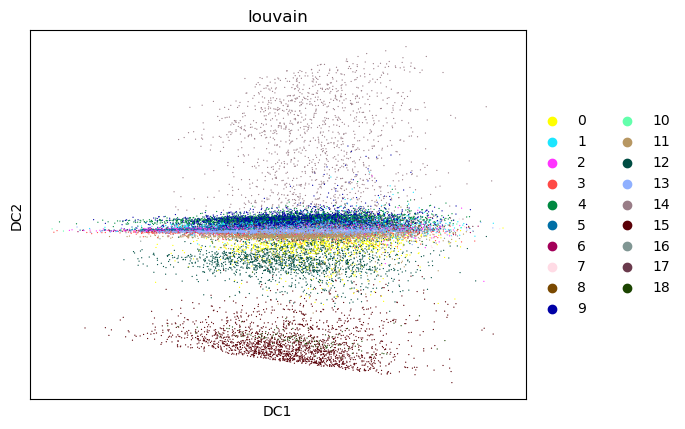

In [57]:
sc.pl.diffmap(tdata, color='louvain')

In [58]:
%%time
rsc.tl.draw_graph(tdata)

CPU times: user 272 ms, sys: 4.29 ms, total: 277 ms
Wall time: 276 ms


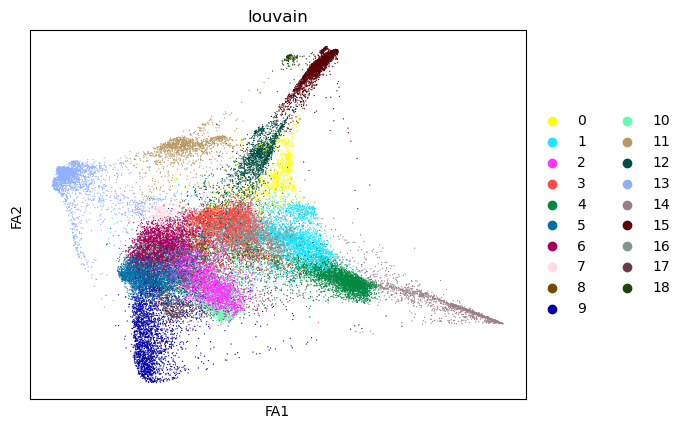

In [59]:
sc.pl.draw_graph(tdata, color='louvain')

After this you can use `X_diffmap` for `sc.pp.neighbors` and other fuctions. 

In [60]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 45.02880525588989
